<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# Group members

**Minimum 2, Maximum 3**

* Ben Kabongo Buzangu


# Presentation of the challenge

## Main question of this challenge

* How to predict the survival of a patient according to their medical files and physiological data?
    
* Specifically, you will need to predict it during their hospital stay
 
Every day, the nursing staff collects information about the patients by asking questions and using measurement tools (stethoscope, blood test, sensors, etc.). These data are very useful for monitoring the state of health, diagnosing, and choosing treatments.

They can also be used for predictive statistical analysis.

## Data

The dataset contains information on 80,000 patients, represented by categorical, binary and, numeric variables (features). These variables are, e.g., age, sex, ethnicity, marital status, as well as medical data such as blood pressure or glucose level. There are a total of 342 variables.

The class to predict is a binary variable indicating whether the patient died or not during his stay in the hospital. Fortunately, most survive:

<!-- #%%[markdown] -->
# ![](img/tobe.png)

References and credit:

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

The link to the challenge:
<https://codalab.lisn.upsaclay.fr/competitions/8802>

* **Step 1:** Register an acount at <https://codalab.lisn.upsaclay.fr>

* **Step 2:** Download the dataset from the [page](https://codalab.lisn.upsaclay.fr/competitions/328#participate-get_starting_kit) `Participate` > `Files` > `Public Data`. Place the `public_data` folder in the same folder as the one containing this notebook.

* **Step 3:** Go through this notebook. You will have to read, execute, **code your own methods** and **answer questions**. Use the ***code*** cell for coding and the ***markdown*** cell to answer questions.

## Project evaluation

* **4 points**: Exploratory analysis

* **4 points**: Clean and well-documented code

* **4 points**: Modeling (selection of the model, selection of hyperparameters)

* **4 points**: Evaluation of the performance of the model

* **4 points**: Quality of the oral presentation

### FAQ

* Submit only the notebook to eCampus (**only 1 per team**)

* The text answers (explanations, results, problems, without the code) must not exceed 1500 words

# Challenge

Prerequisite: `imblearn` (to install with `conda`)

`conda install -c conda-forge imbalanced-learn`

In [1]:
!pip install xgboost

In [2]:
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
    tree,
)

import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler

plt.style.use('seaborn-whitegrid')

In [3]:
%reload_ext autoreload
%autoreload 2

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.1.3

1.1.3


## 1. Understanding the problem

### Metric

Why the metric used here is the [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) rather than simply [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)?

The **balanced_accuracy_score** : `is a metric that is used in classification tasks when the dataset is imbalanced, meaning that the number of samples belonging to each class is not equal. This metric is useful in such cases because it provides a more accurate representation of the performance of the classifier by taking into account the imbalance in the dataset.`

In contrast, the **accuracy_score** : `metric calculates the proportion of correctly classified samples, regardless of the class imbalance in the dataset. This means that in an imbalanced dataset, the accuracy_score may not provide an accurate representation of the performance of the classifier. By using the balanced_accuracy_score instead, you can get a more accurate evaluation of the classifier's performance on imbalanced data.`

## 2. Data loading

In [4]:
DATA = Path("public_data")
assert DATA.is_dir()

PRED_PATH = Path("Submissions")

DROP_FTS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [5]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_FTS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [6]:
x_df

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,75,83.78,89.19,86.05,...,0,0,0,0,0,0,0,0,1,0
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,55,60.88,105.6,80.62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,Medicare,ENGL,NOT_SPECIFIED,UNKNOWN_(DEFAULT),WHITE,F,76,56.04,97.86,79.71,...,0,0,0,0,0,0,0,0,1,0
79995,Medicaid,ENGL,JEWISH,MARRIED,WHITE,F,38,55.13,86.03,67.65,...,0,0,0,0,0,1,0,0,0,0
79996,Private,ENGL,NOT_SPECIFIED,SEPARATED,WHITE,F,90,74.28,91.27,91.43,...,0,0,0,0,0,0,0,0,0,0
79997,Government,ENGL,CATHOLIC,MARRIED,BLACK/AFRICAN_AMERICAN,M,57,79.26,129,98.74,...,0,0,0,0,0,0,0,0,1,0


This is **the training set**. This means that you have access to the labels and can use it however you want to prepare your model.

Later, you will have your model draw predictions from **the test set** in order to upload them to Codalab and get a score on data not seen while training the models.

In [7]:
type(features), len(features), features[:10]

(numpy.ndarray,
 341,
 array(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'INSURANCE',
        'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER'],
       dtype=object))

In [8]:
type(labels), len(labels), labels

(numpy.ndarray, 1, array(['DIED'], dtype=object))

In [9]:
type(ys), len(ys), np.unique(ys)

(pandas.core.series.Series, 79999, array([0, 1]))

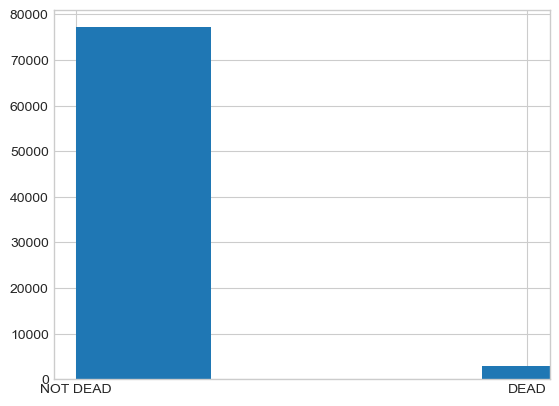

(array([0, 1]), array([77202,  2797]))


In [10]:
plt.hist(ys, width=.3)
plt.xticks([0, 1], labels=['NOT DEAD', 'DEAD'])
plt.show()
print(np.unique(ys, return_counts=True))

In [11]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_FTS, inplace=True)

In [12]:
x_test_df

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0
3,Private,ENGL,OTHER,MARRIED,WHITE,M,80,63.28,85.75,76.75,...,0,0,0,0,0,0,0,0,0,0
4,Medicare,ENGL,JEWISH,WIDOWED,WHITE,M,83,75.23,104.4,94.18,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,85,51.54,72.39,69.96,...,0,0,0,0,0,0,0,0,1,0
19997,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,69,61.79,75.33,80.25,...,0,0,0,0,0,1,0,0,1,0
19998,Medicare,ENGL,CHRISTIAN_SCIENTIST,MARRIED,UNKNOWN/NOT_SPECIFIED,M,84,94.34,132.7,115.4,...,0,0,0,0,0,0,0,0,0,0
19999,Private,ENGL,PROTESTANT_QUAKER,MARRIED,BLACK/AFRICAN_AMERICAN,M,84,48.68,85.93,57.75,...,0,0,0,0,0,0,1,0,0,0


## 3. Exploratory analysis

### Code: Produce the following graphs

* Bar chart to show the target feature distribution

* Bar charts of 4 categorical variables (e.g., "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between a selection of features and the target feature y

* Another graph or any exploratory analysis you can think of

#### Features' types

In [13]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

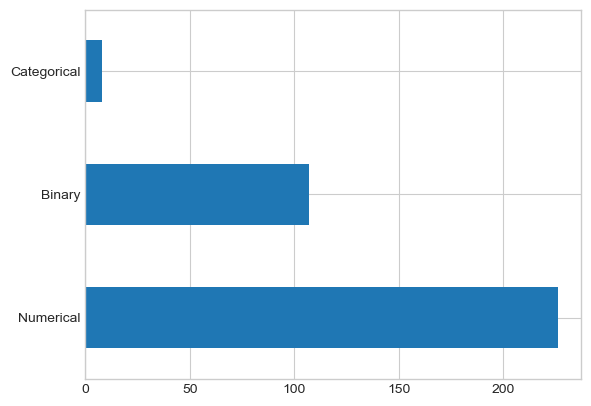

In [14]:
types.value_counts().plot.barh()
plt.show()

#### Target feature distribution

In [15]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

In [16]:
ys.value_counts()

0    77202
1     2797
dtype: int64

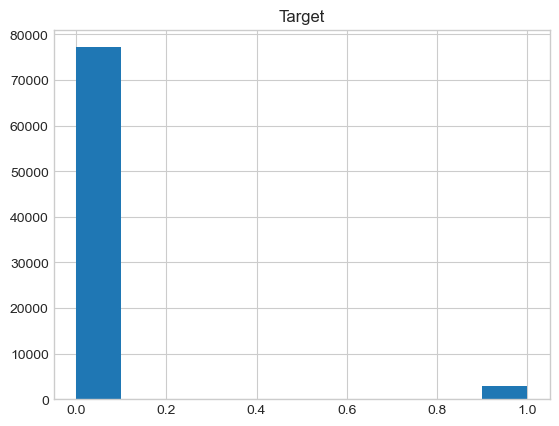

In [17]:
plt.title('Target')
plt.hist(ys)
plt.show()

#### Analysis of features

In [18]:
x_df.describe()

,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,DIAS_BP_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
count,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,...,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04
mean,62.66,71.65,103.1,86.39,94.61,147.8,119.7,45.24,81.99,60.84,...,0,1.25e-05,0,0,0,0.1455,0.1342,0.008625,0.4577,0.07898
std,18.19,14.65,18.48,15.51,16.94,21.61,16.49,10.5,16.64,10.27,...,0,0.003536,0,0,0,0.3526,0.3408,0.09247,0.4982,0.2697
min,16,18.73,49.86,38.5,31.77,91.69,73.97,11.33,42.43,30.5,...,0,0,0,0,0,0,0,0,0,0
25%,51,61.46,89.9,75.28,82.81,132.1,107.6,37.83,69.96,53.4,...,0,0,0,0,0,0,0,0,0,0
50%,65,71.05,101.6,85.42,94.17,145.4,118.1,44.62,79.86,60.1,...,0,0,0,0,0,0,0,0,0,0
75%,77,81.15,114.8,96.51,106,161.1,130.3,51.97,91.76,67.41,...,0,0,0,0,0,0,0,0,1,0
max,90,141.9,206.6,157.6,163.8,260,186.3,95.6,189,109.6,...,0,1,0,0,0,1,1,1,1,1


#### Check null data

In [19]:
res = x_df.isna().sum()
res = res[res > 0]
res

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

#### Unique values

In [20]:
uniques = pd.DataFrame(x_df.nunique()).sort_values(0).rename( {0: 'Uniques'}, axis=1)
uniques

,Uniques
Infectarth,1
Ovariancyst,1
Menopausldx,1
Feminfertil,1
Otfemalgen,1
...,...
GLUCOSE_MAX_DAY1,79546
RESP_RATE_MIN_DAY1,79552
RESP_RATE_MAX_DAY1,79563
RESP_RATE_MIN_DAY2,79576


In [21]:
uniques.describe()

,Uniques
count,337
mean,1.116e+04
std,2.743e+04
min,1
25%,1
50%,1
75%,2
max,7.963e+04


`Features with a single value can be deleted. Indeed, they do not provide any information for the classification.`

**Note:** _Preprocessing task facilitating exploration. Data preprocessing is done in the next part._

In [22]:
single_valued_features = uniques.index[uniques['Uniques'] == 1].tolist()
x_df.drop(columns=single_valued_features, inplace=True)
x_test_df.drop(columns=single_valued_features, inplace=True)
len(single_valued_features)

173

In [23]:
x_df.shape, x_test_df.shape

((79999, 164), (20001, 164))

In [24]:
uniques = pd.DataFrame(x_df.nunique()).sort_values(0).rename( {0: 'Uniques'}, axis=1)
uniques.describe()

,Uniques
count,164
mean,2.293e+04
std,3.576e+04
min,2
25%,2
50%,2
75%,7.525e+04
max,7.963e+04


#### Plot all numerical features

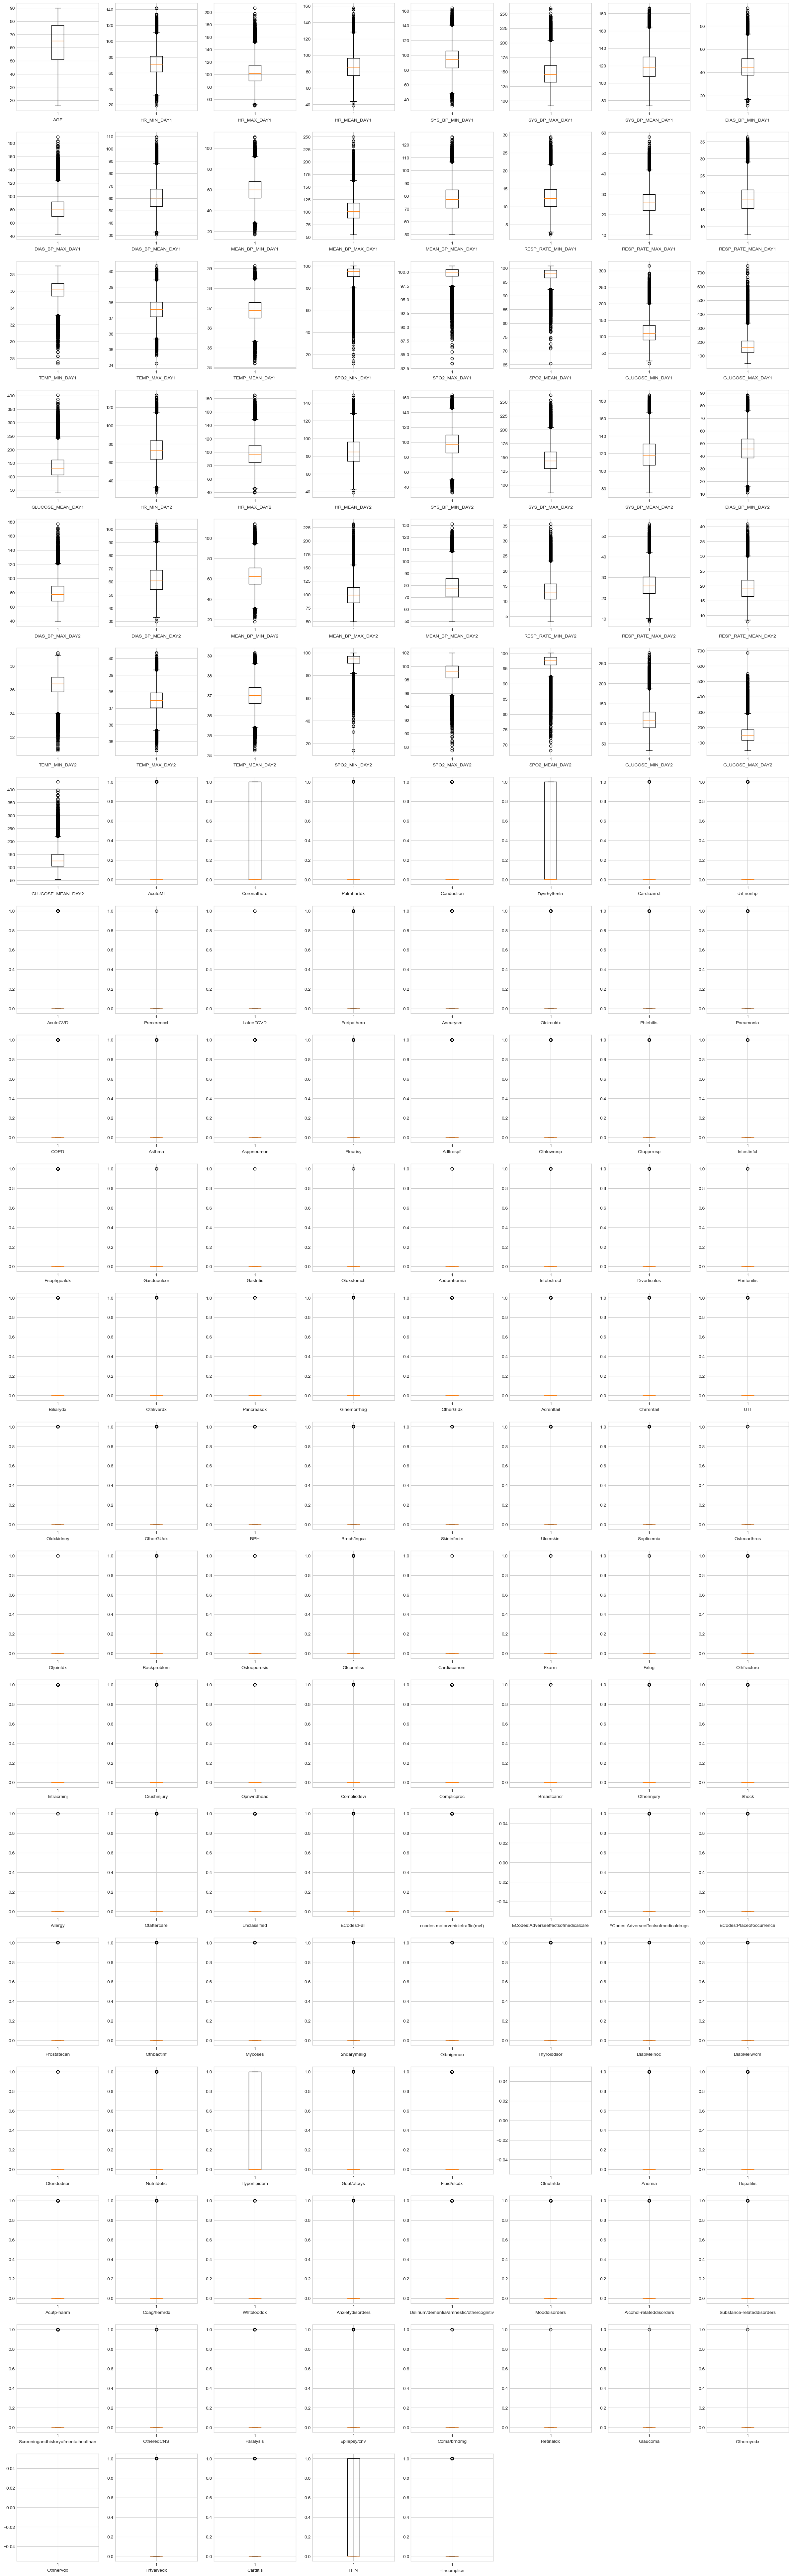

In [25]:
cols = x_df.select_dtypes(include=np.number).columns.tolist()
i = 1
fig = plt.figure(figsize = (30, 100))
for col in cols:
    plt.subplot(20, 8, i)
    plt.boxplot(x_df[col])
    i += 1
    plt.xlabel(col)
plt.show()

#### Categorical features

In [26]:
cols = x_df.select_dtypes(include=object).columns.tolist()
cols

['INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'GENDER',
 'ICU']

Medicare      44670
Private       23964
Medicaid       6434
Government     2933
Self_Pay       1998
Name: INSURANCE, dtype: int64


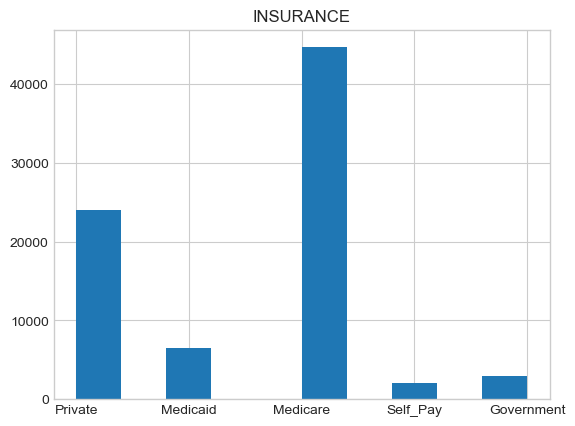

In [27]:
print(x_df['INSURANCE'].value_counts())
x_df['INSURANCE'].hist()
plt.title('INSURANCE')
plt.show()

ENGL    75733
SPAN      871
RUSS      582
PTUN      554
CANT      306
        ...  
SERB        4
*LIT        4
*FAR        3
*YID        3
*PHI        3
Name: LANGUAGE, Length: 68, dtype: int64


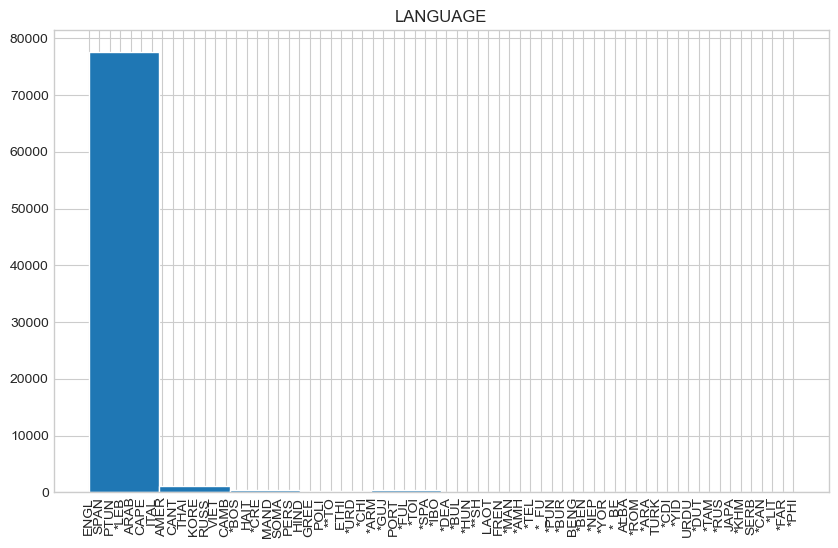

In [28]:
language = x_df['LANGUAGE'].value_counts()
print(language)
x_df['LANGUAGE'].hist(figsize=(10, 6), edgecolor='white')
plt.title('LANGUAGE')
plt.xticks(language.index, rotation=90) 
plt.show()

CATHOLIC                  30384
NOT_SPECIFIED             15110
UNOBTAINABLE               8761
PROTESTANT_QUAKER          8706
JEWISH                     7399
OTHER                      4643
EPISCOPALIAN               1491
GREEK_ORTHODOX              846
CHRISTIAN_SCIENTIST         773
BUDDHIST                    475
MUSLIM                      331
JEHOVAH'S_WITNESS           281
UNITARIAN-UNIVERSALIST      264
HINDU                       170
ROMANIAN_EAST._ORTH         141
7TH_DAY_ADVENTIST           113
BAPTIST                      68
HEBREW                       35
METHODIST                     6
LUTHERAN                      2
Name: RELIGION, dtype: int64


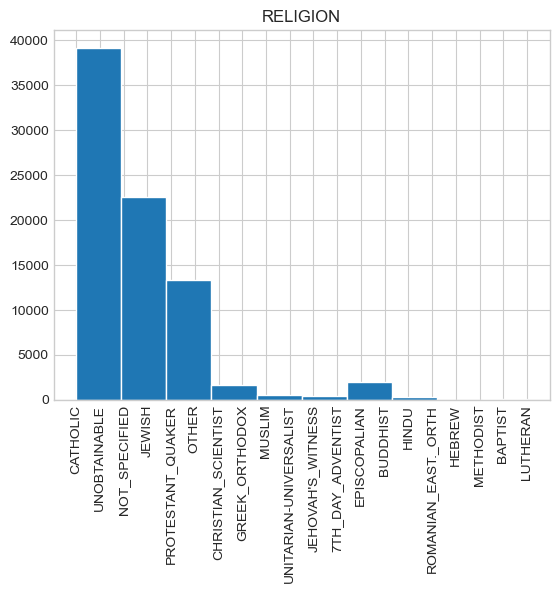

In [29]:
religion = x_df['RELIGION'].value_counts()
print(religion)
x_df['RELIGION'].hist(edgecolor='white')
plt.title('RELIGION')
plt.xticks(religion.index, rotation=90) 
plt.show()

MARRIED              43661
SINGLE               18318
WIDOWED               9375
DIVORCED              5015
UNKNOWN_(DEFAULT)     2114
SEPARATED             1139
LIFE_PARTNER           376
Name: MARITAL_STATUS, dtype: int64


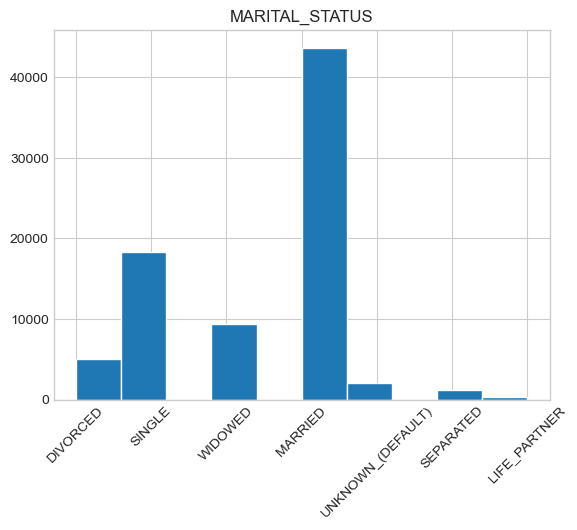

In [30]:
marital = x_df['MARITAL_STATUS'].value_counts()
print(marital)
x_df['MARITAL_STATUS'].hist(edgecolor='white')
plt.title('MARITAL_STATUS')
plt.xticks(marital.index, rotation=45) 
plt.show()

WHITE                                                       59728
UNKNOWN/NOT_SPECIFIED                                        4343
BLACK/AFRICAN_AMERICAN                                       3718
OTHER                                                        1647
HISPANIC_OR_LATINO                                           1429
ASIAN                                                        1416
UNABLE_TO_OBTAIN                                             1384
PATIENT_DECLINED_TO_ANSWER                                   1085
ASIAN_-_CHINESE                                               541
HISPANIC/LATINO_-_PUERTO_RICAN                                466
BLACK/CAPE_VERDEAN                                            426
WHITE_-_RUSSIAN                                               393
MULTI_RACE_ETHNICITY                                          357
HISPANIC/LATINO_-_DOMINICAN                                   290
BLACK/HAITIAN                                                 267
WHITE_-_OT

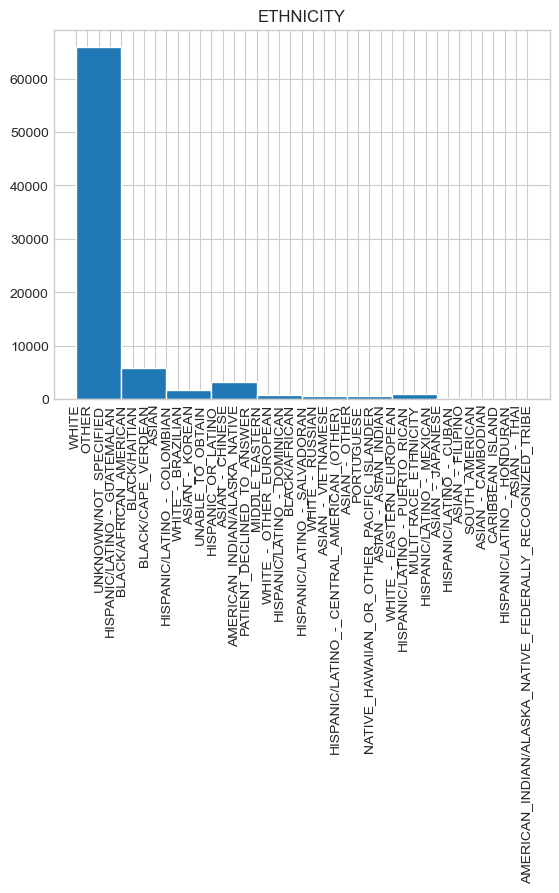

In [31]:
ethnicity = x_df['ETHNICITY'].value_counts()
print(ethnicity)
x_df['ETHNICITY'].hist(edgecolor='white')
plt.title('ETHNICITY')
plt.xticks(ethnicity.index, rotation=90) 
plt.show()

M    46425
F    33574
Name: GENDER, dtype: int64


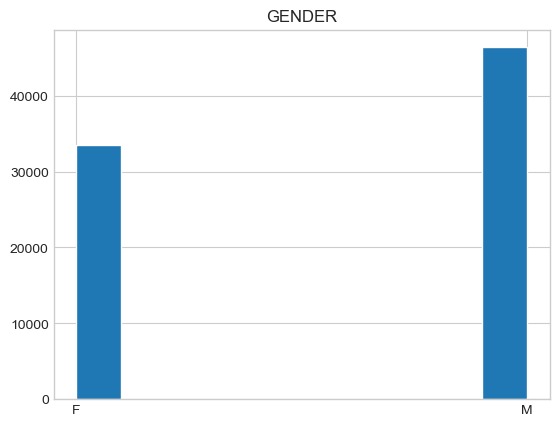

In [32]:
gender = x_df['GENDER'].value_counts()
print(gender)
x_df['GENDER'].hist(edgecolor='white')
plt.title('GENDER')
plt.xticks(gender.index) 
plt.show()

MICU     27780
CSRU     16789
SICU     12803
CCU      11770
TSICU    10855
Name: ICU, dtype: int64


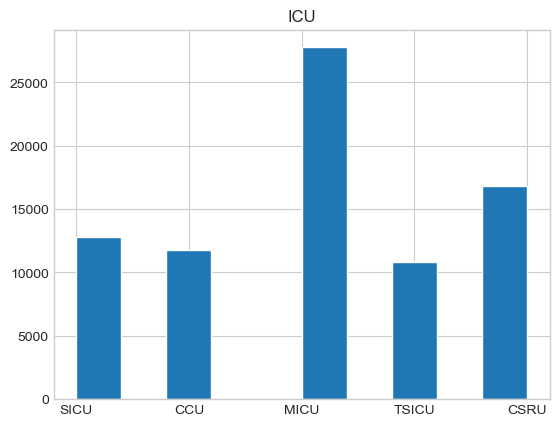

In [33]:
icu = x_df['ICU'].value_counts()
print(icu)
x_df['ICU'].hist(edgecolor='white')
plt.title('ICU')
plt.xticks(icu.index) 
plt.show()

#### Correlation analysis

In [34]:
xy_df = x_df.select_dtypes([np.number]).copy()
xy_df['target'] = ys

Correlation of digital features and the target.

In [35]:
corr = xy_df[xy_df.columns[1:]].corr()['target'][:-1]
corr = corr.sort_values(ascending=False)
corr

RESP_RATE_MEAN_DAY1    0.09577
Adltrespfl             0.09083
RESP_RATE_MAX_DAY1     0.09065
RESP_RATE_MEAN_DAY2    0.08938
RESP_RATE_MAX_DAY2     0.08614
                        ...   
DIAS_BP_MIN_DAY1       -0.0449
Hyperlipidem          -0.04607
SYS_BP_MIN_DAY1       -0.04932
MEAN_BP_MIN_DAY2      -0.05391
DIAS_BP_MIN_DAY2      -0.05402
Name: target, Length: 156, dtype: float64

Representation of the first 20 features most correlated with the target.

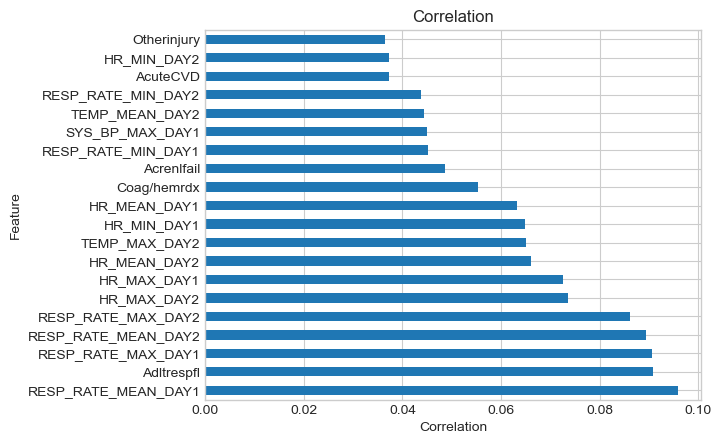

In [36]:
corr[:20].plot.barh()
plt.title('Correlation')
plt.ylabel('Feature')
plt.xlabel('Correlation')
plt.show()

Correlation of categorical features and the target.

In [37]:
xy_df = x_df.select_dtypes([object]).copy()
xy_df['target'] = ys

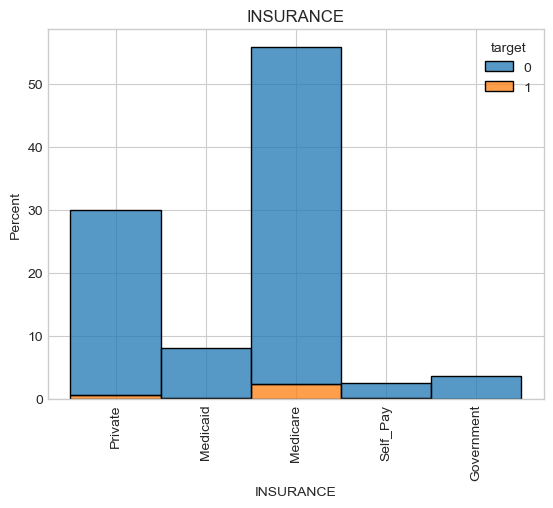

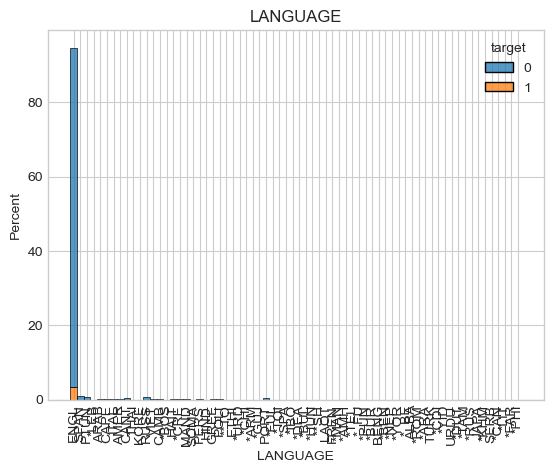

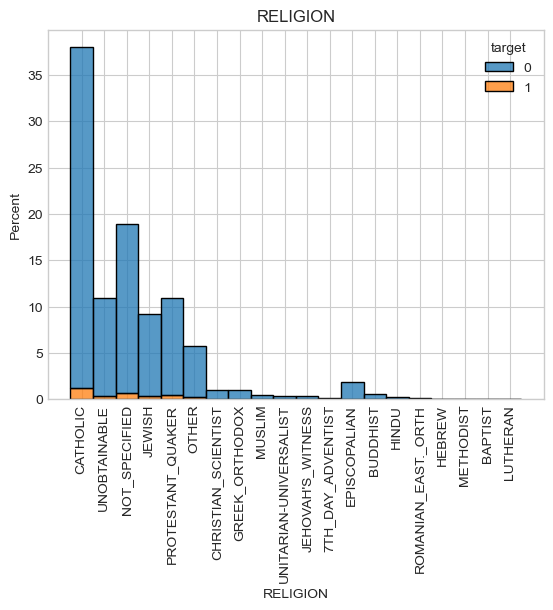

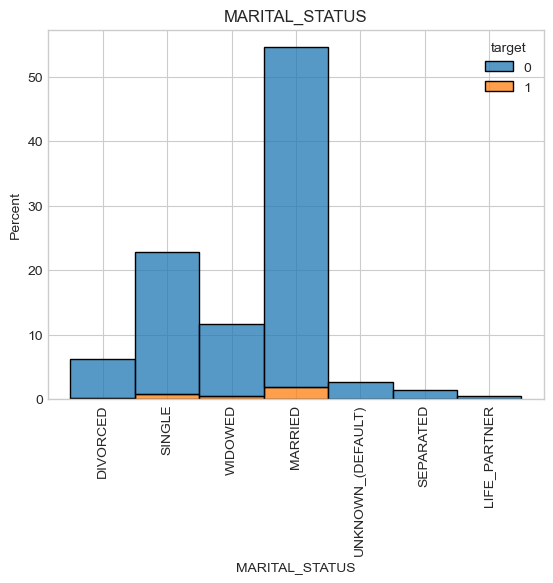

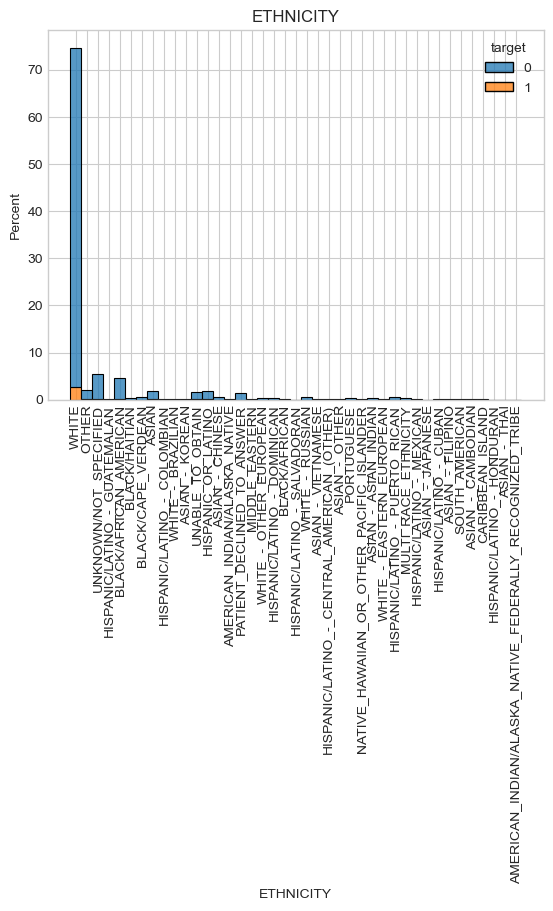

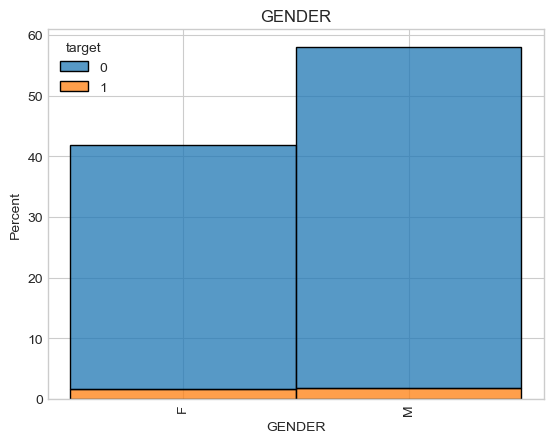

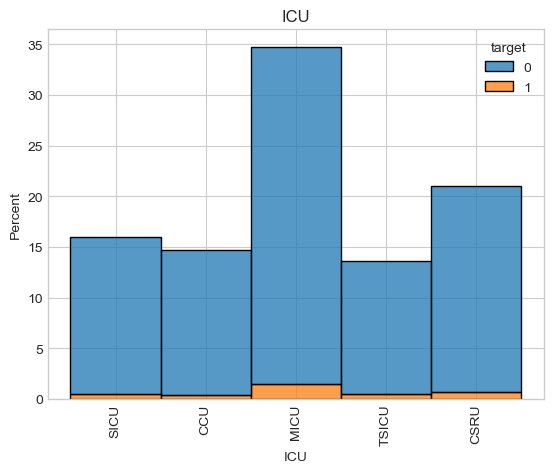

In [38]:
for col in xy_df.columns:
    if col == 'target': continue
    group = xy_df.groupby(col).count()['target']
    plt.figure()
    plt.title(col)
    sns.histplot(data=xy_df, x=col, hue="target", multiple="stack", stat="percent")
    plt.xticks(rotation=90)


## 4. Preprocessing

### Code: Missing values handling

The simplest solution is to eliminate all the columns where there is missing data, but a large part of the information may be lost.

If a small number of instances is concerned, it is more pertinent to delete the rows (instances) rather than the entire columns (variables). But you need to **pay attention**, if you **cannot** change the number of rows in the **test set**, or the competition grader will **fail**.

A third solution would be to replace undefined values with the most probable value of the variable. As these missing values relate exclusively to categorical and binary variables, the most probable value is the [*mode*](https://en.wikipedia.org/wiki/Mode_(statistics)).

A first baseline version is given, but it should be improved. It discards all categorical features and instances with NAN.

In [39]:
print(x_df.shape, x_test_df.shape)

x_baseline_df = x_df.select_dtypes([np.number]).copy()
x_baseline_test_df = x_test_df.select_dtypes([np.number]).copy()

x_baseline_df.fillna(0, inplace=True)
x_baseline_test_df.fillna(0, inplace=True)

print(x_baseline_df.shape, x_baseline_test_df.shape)

(79999, 164) (20001, 164)
(79999, 157) (20001, 157)


#### Exploration

First check the number of missing data per features and per instances (patient). Don't forget to process both the training and the test sets!

In [40]:
res = x_df.isna().sum()
res = res[res > 0]
res

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

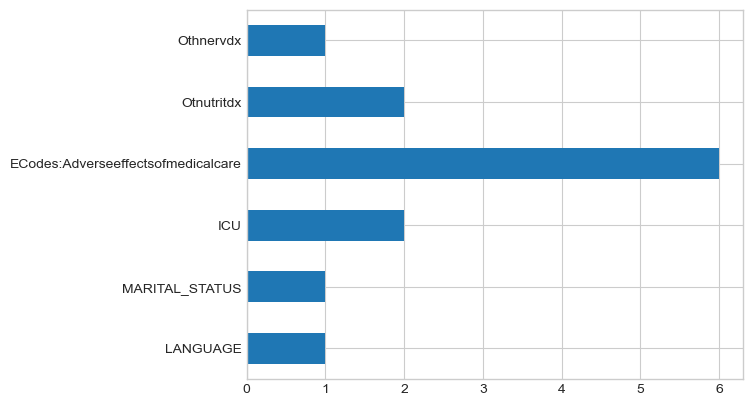

In [41]:
res.plot.barh()
plt.show()

In [42]:
res = x_test_df.isna().sum()
res = res[res > 0]
res

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [43]:
x_df.shape, ys.shape

((79999, 164), (79999,))

In [44]:
x_df['MARITAL_STATUS'].unique()

array(['DIVORCED', 'SINGLE', 'WIDOWED', 'MARRIED', 'UNKNOWN_(DEFAULT)',
       'SEPARATED', 'LIFE_PARTNER', nan], dtype=object)

`Missing values of the MARITAL_STATUS feature can be replaced by its default value : UNKNOWN_(DEFAULT)`.

In [45]:
x_df['MARITAL_STATUS'].fillna('UNKNOWN_(DEFAULT)', inplace=True)
x_df['MARITAL_STATUS'].isna().sum(), x_test_df['MARITAL_STATUS'].isna().sum()

(0, 0)

`Missing values of the LANGUAGE and ICU features can be replaced by theirs more frequents values`.

In [46]:
x_df['LANGUAGE'].fillna('ENGL', inplace=True)
x_test_df['LANGUAGE'].fillna('ENGL', inplace=True)
x_df['LANGUAGE'].isna().sum(), x_test_df['LANGUAGE'].isna().sum()

(0, 0)

In [47]:
x_df['ICU'].fillna('MICU', inplace=True)
x_test_df['ICU'].fillna('MICU', inplace=True)
x_df['ICU'].isna().sum(), x_test_df['ICU'].isna().sum()

(0, 0)

#### Fixing

Now you can apply your chosen strategy

`We choose to replace the missing numerical values, for each feature, by its most frequent value.`

In [48]:
v = {
    'ECodes:Adverseeffectsofmedicalcare': x_df['ECodes:Adverseeffectsofmedicalcare'].mode()[0], 
    'Otnutritdx': x_df['Otnutritdx'].mode()[0], 
    'Othnervdx': x_df['Othnervdx'].mode()[0]
}
x_df.fillna(value=v, inplace=True)
x_test_df.fillna(value=v, inplace=True)

In [49]:
res = x_df.isna().sum()
res = res[res > 0]
res

Series([], dtype: int64)

In [50]:
res = x_test_df.isna().sum()
res = res[res > 0]
res

Series([], dtype: int64)

### Reduce data scarcity (not enough data per class)

For example, you could simplify data by grouping rare categories.

In [51]:
cols = x_df.select_dtypes(include=object).columns.tolist()
for col in cols:
    print('\n===================== ' + col.center(20) + ' ===================== ')
    print(x_df[col].value_counts())


=====================      INSURANCE       ===================== 
Medicare      44670
Private       23964
Medicaid       6434
Government     2933
Self_Pay       1998
Name: INSURANCE, dtype: int64

=====================       LANGUAGE       ===================== 
ENGL    75734
SPAN      871
RUSS      582
PTUN      554
CANT      306
        ...  
SERB        4
*LIT        4
*FAR        3
*YID        3
*PHI        3
Name: LANGUAGE, Length: 68, dtype: int64

=====================       RELIGION       ===================== 
CATHOLIC                  30384
NOT_SPECIFIED             15110
UNOBTAINABLE               8761
PROTESTANT_QUAKER          8706
JEWISH                     7399
OTHER                      4643
EPISCOPALIAN               1491
GREEK_ORTHODOX              846
CHRISTIAN_SCIENTIST         773
BUDDHIST                    475
MUSLIM                      331
JEHOVAH'S_WITNESS           281
UNITARIAN-UNIVERSALIST      264
HINDU                       170
ROMANIAN_EAST._ORTH       

`We are going to focus on the "language" feature and create a new category of language in which we will then place the languages spoken by less than 400 individuals.`

In [52]:
res = x_df['LANGUAGE'].value_counts()
res = res[res < 400]
res

CANT    306
PORT    290
CAPE    220
HAIT    129
MAND    113
       ... 
SERB      4
*LIT      4
*FAR      3
*YID      3
*PHI      3
Name: LANGUAGE, Length: 64, dtype: int64

In [53]:
x_df['LANGUAGE'] = x_df['LANGUAGE'].replace(list(res.index), 'OTHER')
x_test_df['LANGUAGE'] = x_test_df['LANGUAGE'].replace(list(res.index), 'OTHER')

In [54]:
x_df['LANGUAGE'].value_counts()

ENGL     75734
OTHER     2258
SPAN       871
RUSS       582
PTUN       554
Name: LANGUAGE, dtype: int64

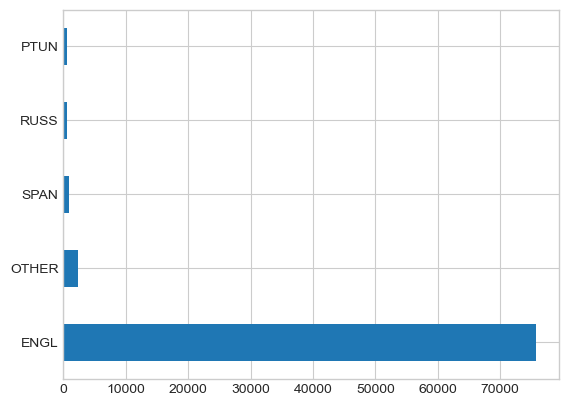

In [55]:
x_df['LANGUAGE'].value_counts().plot.barh()
plt.show()

`We are going to focus on the "religion" feature and create a new category of religion in which we will then place the religion less than 1000 individuals.`

In [56]:
res = x_df['RELIGION'].value_counts()
res = res[res < 1000]
res

GREEK_ORTHODOX            846
CHRISTIAN_SCIENTIST       773
BUDDHIST                  475
MUSLIM                    331
JEHOVAH'S_WITNESS         281
UNITARIAN-UNIVERSALIST    264
HINDU                     170
ROMANIAN_EAST._ORTH       141
7TH_DAY_ADVENTIST         113
BAPTIST                    68
HEBREW                     35
METHODIST                   6
LUTHERAN                    2
Name: RELIGION, dtype: int64

In [57]:
x_df['RELIGION'] = x_df['RELIGION'].replace(list(res.index), 'OTHER')
x_test_df['RELIGION'] = x_test_df['RELIGION'].replace(list(res.index), 'OTHER')

In [58]:
x_df['RELIGION'].value_counts()

CATHOLIC             30384
NOT_SPECIFIED        15110
UNOBTAINABLE          8761
PROTESTANT_QUAKER     8706
OTHER                 8148
JEWISH                7399
EPISCOPALIAN          1491
Name: RELIGION, dtype: int64

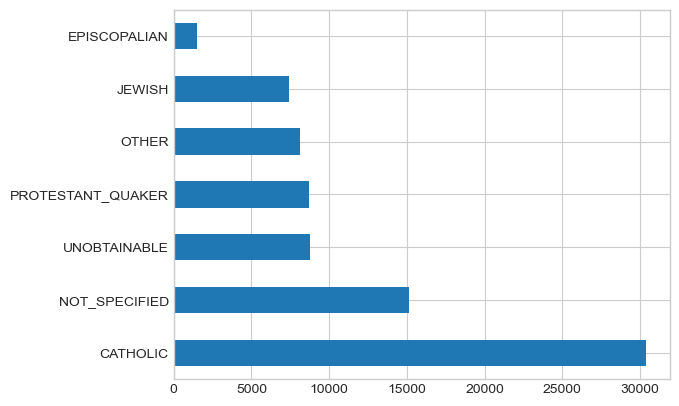

In [59]:
x_df['RELIGION'].value_counts().plot.barh()
plt.show()

`We are going to focus on the "ethnicity" feature and create a new category of ethnicity in which we will then place the ethnicity less than 1000 individuals.`

In [60]:
res = x_df['ETHNICITY'].value_counts()
res = res[res < 1000]
res

ASIAN_-_CHINESE                                             541
HISPANIC/LATINO_-_PUERTO_RICAN                              466
BLACK/CAPE_VERDEAN                                          426
WHITE_-_RUSSIAN                                             393
MULTI_RACE_ETHNICITY                                        357
HISPANIC/LATINO_-_DOMINICAN                                 290
BLACK/HAITIAN                                               267
WHITE_-_OTHER_EUROPEAN                                      266
ASIAN_-_ASIAN_INDIAN                                        246
PORTUGUESE                                                  213
WHITE_-_BRAZILIAN                                           205
ASIAN_-_VIETNAMESE                                          189
BLACK/AFRICAN                                               176
HISPANIC/LATINO_-_GUATEMALAN                                136
AMERICAN_INDIAN/ALASKA_NATIVE                               132
MIDDLE_EASTERN                          

In [61]:
x_df['ETHNICITY'] = x_df['ETHNICITY'].replace(list(res.index), 'OTHER')
x_test_df['ETHNICITY'] = x_test_df['ETHNICITY'].replace(list(res.index), 'OTHER')

In [62]:
x_df['RELIGION'].value_counts()

CATHOLIC             30384
NOT_SPECIFIED        15110
UNOBTAINABLE          8761
PROTESTANT_QUAKER     8706
OTHER                 8148
JEWISH                7399
EPISCOPALIAN          1491
Name: RELIGION, dtype: int64

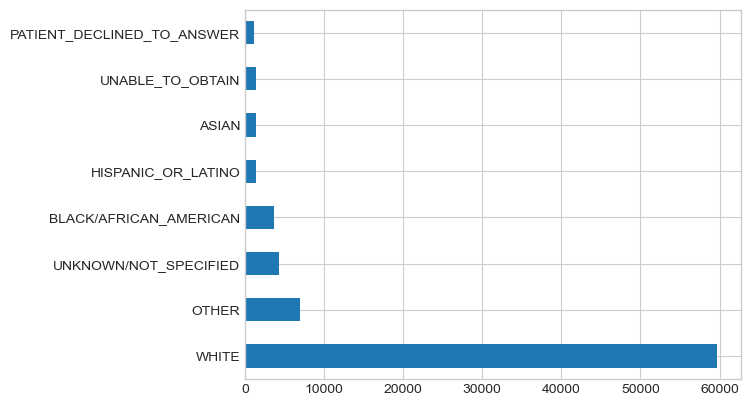

In [63]:
x_df['ETHNICITY'].value_counts().plot.barh()
plt.show()

In [64]:
x_df.shape

(79999, 164)

### Transforming categorical data into integers using two types of encoding

Categorical variables are presented in the form of character strings. Most models will not be able to handle them in such a format.

#### Simple digital encoding

Two of the simplest methods are `LabelEncoder` from Scikit-Learn and` factorize` from pandas. They simply consist of replacing each new category encountered with an integer, starting with 0. This is perhaps not the most efficient method, since it presupposes proximity between the categories coded with close values.

#### 1-Hot encoding

Another type of encoding is often more efficient, in particular, it has the advantage of not ordering the classes in a particular way (not necessarily in line with the proximity of these classes to each other).

A pandas method allows this to be done in 1 line of code with the `get_dummies` function.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

You can choose your preferred way of encoding the categorical data.

In [65]:
X = pd.concat([x_df, x_test_df])
X_dummies = pd.get_dummies(X)
xd_df = X_dummies[:len(x_df)]
xd_test_df = X_dummies[len(x_df):]
assert len(xd_df) == len(x_df) and len(xd_test_df) == len(x_test_df)
xd_df.shape, xd_test_df.shape

((79999, 196), (20001, 196))

#### Removing single-valued variables (constants)

`Done in step 1`

### Creation of the validation set

In [66]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    xd_df, ys, test_size=0.3
)

### Size reduction via PCA

Test the PCA to reduce the number of dimensions and see if this improves the result.

Before applying the PCA, it is advisable to standardize the data.

In [67]:
scaler = preprocessing.StandardScaler().fit(x_train)
xs_train = scaler.transform(x_train)
xs_valid = scaler.transform(x_valid)

In [68]:
xs_test = scaler.transform(xd_test_df)

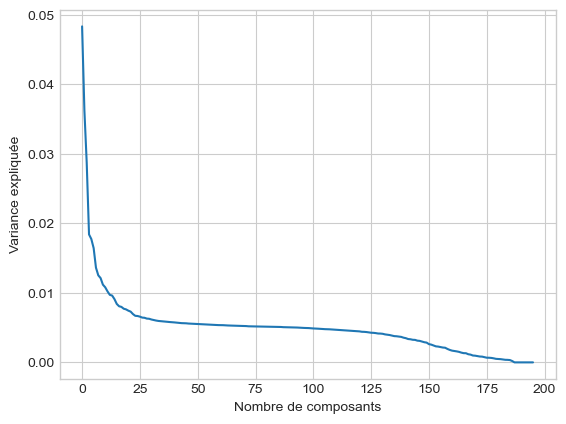

Nombre de composants : 149


In [69]:
pca = decomposition.PCA()

pca.fit(xs_train)

explained_variance = pca.explained_variance_ratio_

plt.plot(explained_variance)
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée')
plt.show()

# Choix du nombre de composants à utiliser (par exemple, celui qui explique 95 % de la variance)
threshold = 0.95
n_components = next(i for i, j in enumerate(np.cumsum(explained_variance)) if j >= threshold) + 1
print('Nombre de composants :', n_components)

In [70]:
# Choix du nombre de composants à utiliser (par exemple, celui qui explique 75 % de la variance)
threshold = 0.75
n_components2 = next(i for i, j in enumerate(np.cumsum(explained_variance)) if j >= threshold) + 1
print('Nombre de composants :', n_components2)

Nombre de composants : 101


In [71]:
pca = decomposition.PCA(n_components=n_components2)
pca_train = pca.fit_transform(xs_train)
pca_valid = pca.fit_transform(xs_valid)
pca_train.shape, pca_valid.shape

((55999, 101), (24000, 101))

In [72]:
pca_test = pca.fit_transform(xs_test)

Print a graph that represents the first 2 dimensions of PCA and comment briefly.

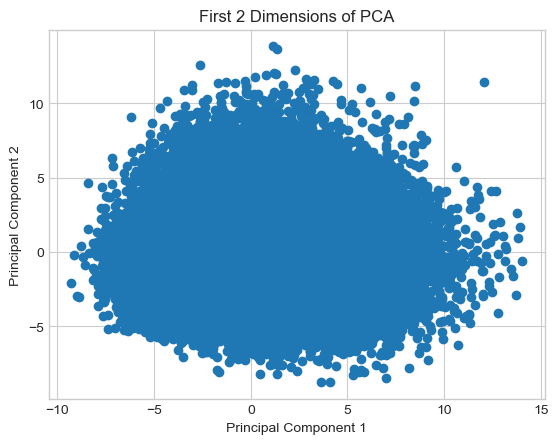

In [73]:
plt.scatter(pca_train[:, 0], pca_train[:, 1])
plt.title("First 2 Dimensions of PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

`We observe a strong correlation between the first two components of the principal component analysis`

## 5 & 6. Classification models & Evaluations

### First attempt

In [74]:
models = [linear_model.LogisticRegression(C=1),
          tree.DecisionTreeClassifier(),
          svm.SVC(C=1),
          ensemble.RandomForestClassifier()]

models_scores = dict()
for model in models:
    scores = [] # score train and valid
    model.fit(pca_train, y_train)
    y_pred = model.predict(pca_train)
    scores.append(metrics.balanced_accuracy_score(y_train, y_pred))
    y_pred = model.predict(pca_valid)
    scores.append(metrics.balanced_accuracy_score(y_valid, y_pred))
    models_scores[model.__class__.__name__] = scores
    print(model.__class__.__name__, ':', scores)

LogisticRegression : [0.5057244605752267, 0.4988756756756757]
DecisionTreeClassifier : [1.0, 0.5062826254826255]
SVC : [0.5057232049947971, 0.5]
RandomForestClassifier : [0.9992195629552549, 0.5]


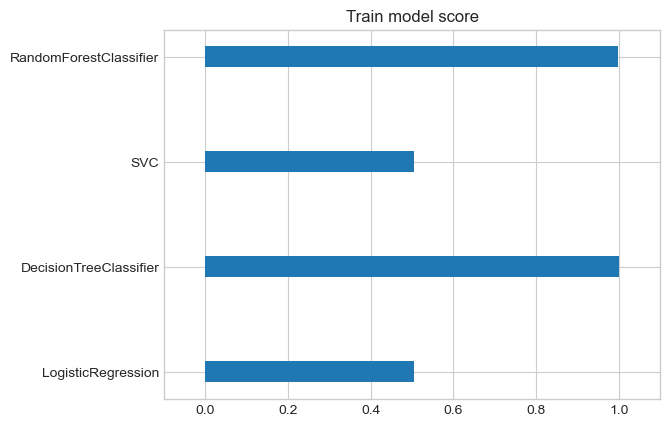

In [75]:
plt.figure()
plt.title('Train model score')
models_names = list(models_scores.keys())
models_train_scores = [models_scores[m][0] for m in models_names]
plt.barh(range(4), models_train_scores, height=0.2)
plt.yticks(range(4), models_names)
plt.xlim(-0.1, 1.1)
plt.show()

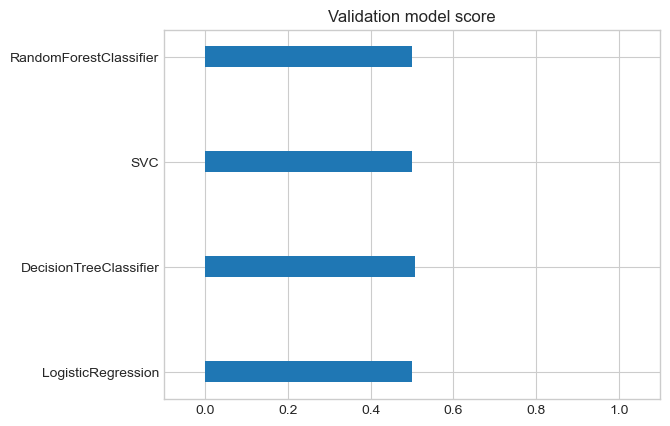

In [76]:
plt.figure()
plt.title('Validation model score')
models_names = list(models_scores.keys())
models_train_scores = [models_scores[m][1] for m in models_names]
plt.barh(range(4), models_train_scores, height=0.2)
plt.yticks(range(4), models_names)
plt.xlim(-0.1, 1.1)
plt.show()

### Second attempt : RandomUnderSampler

```The far too great imbalance that there is between the two classes poses a lot of problems to our classifiers who generalize badly. To overcome this problem, we will use a sampling technique that allows us to better sample our data to increase the performance of our classifications.```

In [77]:
# échantillonnage aléatoire sous-échantillonnage pour équilibrer les classes
sampler = RandomUnderSampler(sampling_strategy='majority')
pca_train, y_train = sampler.fit_resample(pca_train, y_train)
pca_valid, y_valid = sampler.fit_resample(pca_valid, y_valid)

In [78]:
models = [linear_model.LogisticRegression(C=1),
          tree.DecisionTreeClassifier(),
          svm.SVC(C=1),
          ensemble.RandomForestClassifier()]

models_scores = dict()
for model in models:
    scores = [] # score train and valid
    model.fit(pca_train, y_train)
    y_pred = model.predict(pca_train)
    scores.append(metrics.balanced_accuracy_score(y_train, y_pred))
    y_pred = model.predict(pca_valid)
    scores.append(metrics.balanced_accuracy_score(y_valid, y_pred))
    models_scores[model.__class__.__name__] = scores
    print(model.__class__.__name__, ':', scores)

LogisticRegression : [0.7304890738813736, 0.5565714285714285]
DecisionTreeClassifier : [1.0, 0.5314285714285714]
SVC : [0.8376690946930281, 0.5559999999999999]
RandomForestClassifier : [1.0, 0.5588571428571428]


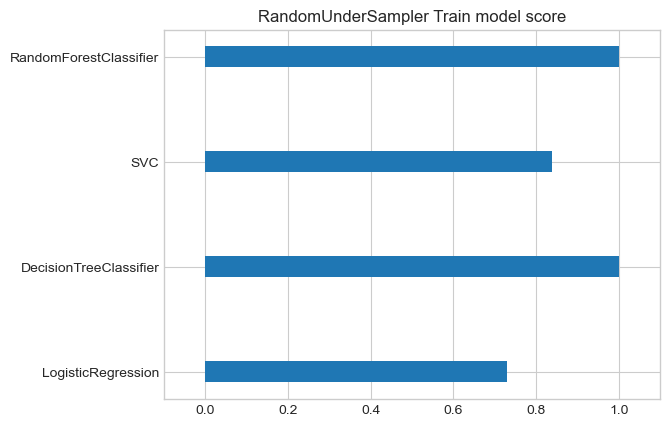

In [79]:
plt.figure()
plt.title('RandomUnderSampler Train model score')
models_names = list(models_scores.keys())
models_train_scores = [models_scores[m][0] for m in models_names]
plt.barh(range(4), models_train_scores, height=0.2)
plt.yticks(range(4), models_names)
plt.xlim(-0.1, 1.1)
plt.show()

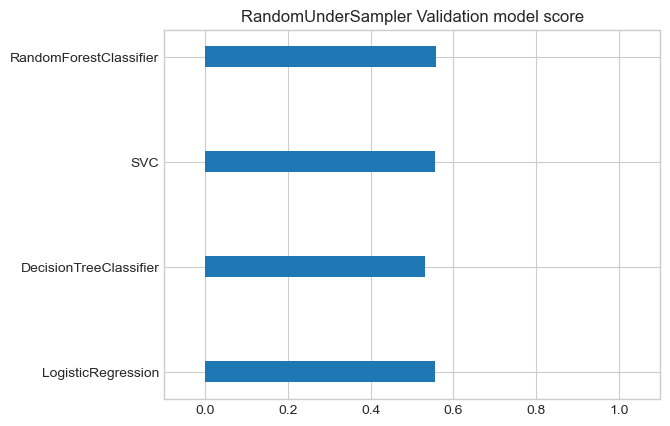

In [80]:
plt.figure()
plt.title('RandomUnderSampler Validation model score')
models_names = list(models_scores.keys())
models_train_scores = [models_scores[m][1] for m in models_names]
plt.barh(range(4), models_train_scores, height=0.2)
plt.yticks(range(4), models_names)
plt.xlim(-0.1, 1.1)
plt.show()

### Third attempt : XGBoost

In [81]:
# conversion les données en format compatible avec XGBoost
train_xgb = xgb.DMatrix(np.array(pca_train), label=y_train)
valid_xgb = xgb.DMatrix(np.array(pca_valid), label=y_valid)

# hyperparamètres de l'estimateur XGBoost
params = {'eta': 0.1, 'objective': 'binary:logistic', 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 1}

model = xgb.train(params, train_xgb, num_boost_round=100, evals=[(train_xgb, 'train'), (valid_xgb, 'valid')])

print('\n=====================================================')
y_pred = np.round(model.predict(train_xgb))
score = metrics.balanced_accuracy_score(y_train, y_pred)
print("Balanced accuracy score Train :", score)

y_pred = np.round(model.predict(valid_xgb))
score = metrics.balanced_accuracy_score(y_valid, y_pred)
print("Balanced accuracy score Validation :", score)


[0]	train-logloss:0.66939	valid-logloss:0.68805
[1]	train-logloss:0.64836	valid-logloss:0.68428
[2]	train-logloss:0.63050	valid-logloss:0.68291
[3]	train-logloss:0.61375	valid-logloss:0.68487
[4]	train-logloss:0.59726	valid-logloss:0.68484
[5]	train-logloss:0.58136	valid-logloss:0.68711
[6]	train-logloss:0.56667	valid-logloss:0.68831
[7]	train-logloss:0.55445	valid-logloss:0.69106
[8]	train-logloss:0.54215	valid-logloss:0.68874
[9]	train-logloss:0.53116	valid-logloss:0.68987
[10]	train-logloss:0.51978	valid-logloss:0.69133
[11]	train-logloss:0.50784	valid-logloss:0.69024
[12]	train-logloss:0.49711	valid-logloss:0.69114
[13]	train-logloss:0.48628	valid-logloss:0.69268
[14]	train-logloss:0.47546	valid-logloss:0.69628
[15]	train-logloss:0.46693	valid-logloss:0.69847
[16]	train-logloss:0.45845	valid-logloss:0.69807
[17]	train-logloss:0.45020	valid-logloss:0.70169
[18]	train-logloss:0.44178	valid-logloss:0.70348
[19]	train-logloss:0.43404	valid-logloss:0.70714
[20]	train-logloss:0.42571	val

### Code: Cross-validation

Use cross-validation (to get a more reliable estimate) combined with an exploration of hyperparameters (to improve results).

You can change the value of the cross-validation number (CV) depending on the error value and the time to train the models (compromise).

In [82]:
models = [linear_model.LogisticRegression(),
          tree.DecisionTreeClassifier(),
          svm.SVC(),
          ensemble.RandomForestClassifier()]

parameters = {
    "LogisticRegression": {"penalty": ["l2",], "C": [0.001, 0.01, 0.1, 1, 10]},
    "DecisionTreeClassifier": {"max_depth": [3, 5, 7, 9, None], "min_samples_split": [2, 3, 4, 5]},
    "SVC": {"C": [0.01, 0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "RandomForestClassifier": {"n_estimators": [10, 50, 100, 200], "max_depth": [3, 5, 7, None]}
}

models_scores = dict()

for model in models:
    model_name = model.__class__.__name__
    model_parameters = parameters[model_name]
    clf = model_selection.GridSearchCV(model, model_parameters, cv=5, scoring="balanced_accuracy")
    clf.fit(pca_train, y_train)
    models_scores[model_name] = clf.best_score_
    print(model_name, ":", clf.best_score_)


/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

LogisticRegression : 0.7104545454545454
DecisionTreeClassifier : 0.6324391233766234
SVC : 0.7213873106060606
RandomForestClassifier : 0.6974418290043289


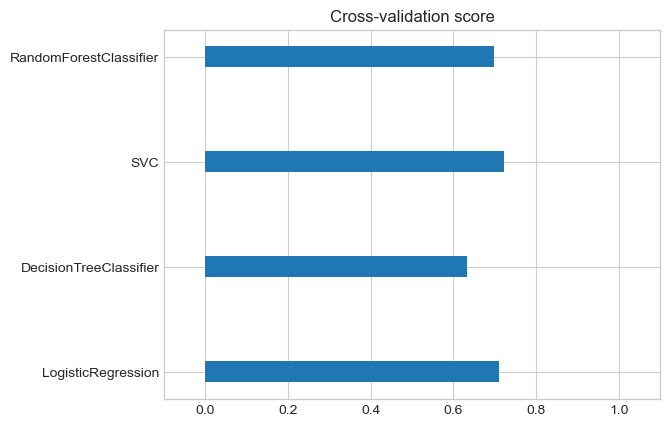

In [83]:
plt.figure()
plt.title('Cross-validation score')
models_names = list(models_scores.keys())
models_train_scores = [models_scores[m] for m in models_names]
plt.barh(range(4), models_train_scores, height=0.2)
plt.yticks(range(4), models_names)
plt.xlim(-0.1, 1.1)
plt.show()

* **For 2 of the models** (at least 1 other than the proposed baseline):

    * For different values of one of the hyperparameters, give the average `balanced_accuracy` of the cross-validation in the form of Boxplots (or bar graph with an error bar): see the example presented in the graph below.
    
    * Briefly explain what observations to draw concerning the stability of the predictions.

![](img/boxplot-cv.png)

**SVM**

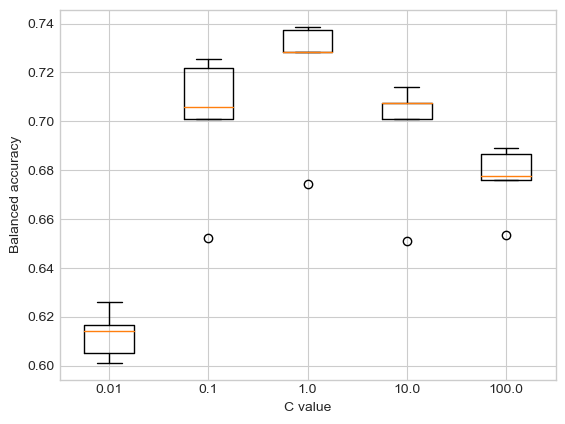

In [84]:
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]

results = {}

for C in C_values:
    clf = svm.SVC(C=C)
    scores = model_selection.cross_validate(clf, pca_train, y_train, cv=5, scoring="balanced_accuracy")
    results[C] = scores["test_score"]

fig, ax = plt.subplots()
ax.boxplot(results.values(), labels=results.keys())
ax.set_xlabel("C value")
ax.set_ylabel("Balanced accuracy")
plt.show()

**LogisticRegression**

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

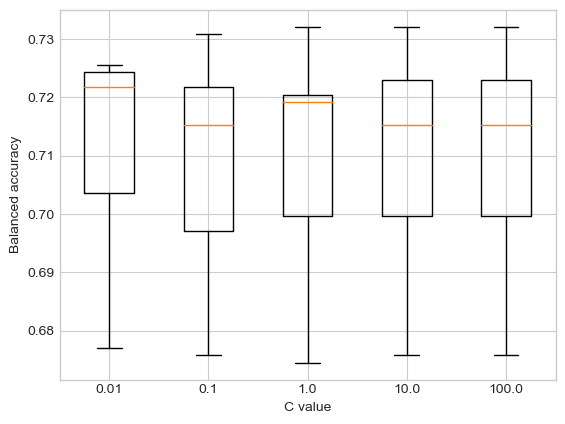

In [85]:
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]

results = {}

for C in C_values:
    clf = linear_model.LogisticRegression(C=C)
    scores = model_selection.cross_validate(clf, pca_train, y_train, cv=5, scoring="balanced_accuracy")
    results[C] = scores["test_score"]

fig, ax = plt.subplots()
ax.boxplot(results.values(), labels=results.keys())
ax.set_xlabel("C value")
ax.set_ylabel("Balanced accuracy")
plt.show()

* **For each of these 2 models, from the validation data created previously** (`x_valid`,` y_valid`):

    * Measure the area under the ROC curve (AUC) using the Scikit-Learn (`roc_auc_score`) function and compare the models with their respective combination of hyperparameters giving the best result.

In [86]:
model = svm.SVC(C=1, probability=True)
model.fit(pca_train, y_train)

y_pred_proba = model.predict_proba(pca_valid)

auc = metrics.roc_auc_score(y_valid, y_pred_proba[:,1])
print("AUC SVC :", auc)

AUC SVC : 0.5513730612244898


In [87]:
model = linear_model.LogisticRegression(C=1)
model.fit(pca_train, y_train)

y_pred_proba = model.predict_proba(pca_valid)

auc = metrics.roc_auc_score(y_valid, y_pred_proba[:,1])
print("AUC Logistic Regression :", auc)

AUC Logistic Regression : 0.5585580408163265


```It can be inferred that the SVC model performs better than the logistic regression model in terms of AUC. This means that the SVC model is better at predicting two-category classes in the validation data, comparing with the logistic regression model.```

* **For the model and its combination of hyperparameters offering the best result**:

    * Present the confusion matrix and describe it succinctly.

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


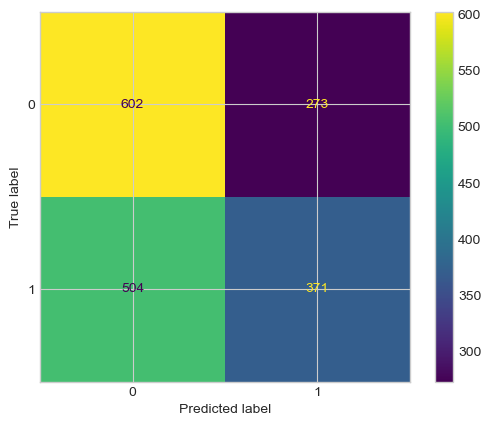

In [88]:
model = svm.SVC(C=1)
model.fit(pca_train, y_train)
y_pred = model.predict(pca_valid)
metrics.plot_confusion_matrix(model, pca_valid, y_valid)
plt.show()

### Code: Try to improve your score

* Data augmentation (optional)

Given the imbalance between the classes to predict (survive, died), we can hope to improve the score by rebalancing them. A typical approach is through data generation. One of the generation methods is [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE). For instance, it is implemented in the `imblearn` library.

`imblearn` was developed to fit the `sklearn` API.
In particular, it offers a version of the `pipeline` which allows integration with `sklearn`.

In [89]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# pipeline
pipeline = Pipeline([
    ('smote', SMOTE()),
    ('model', svm.SVC())
])

In [90]:
scores = model_selection.cross_val_score(pipeline, pca_train, y_train, cv=5, scoring="balanced_accuracy")
pipeline.fit(pca_train, y_train)
y_pred = pipeline.predict(pca_valid)

In [93]:
print(scores)

[0.731 0.739 0.728 0.739 0.674]


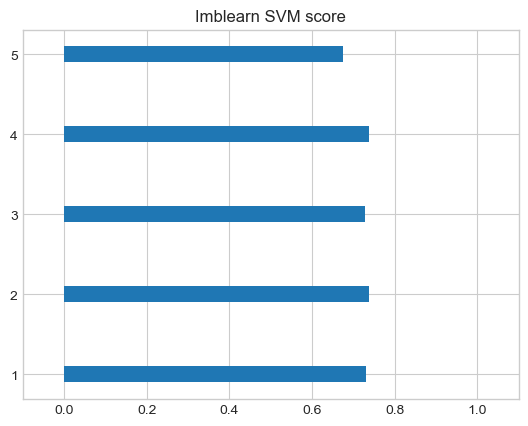

In [96]:
plt.figure()
plt.title('Imblearn SVM score')
models_names = range(1,6)
plt.barh(range(5), scores, height=0.2)
plt.yticks(range(5), models_names)
plt.xlim(-0.1, 1.1)
plt.show()

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


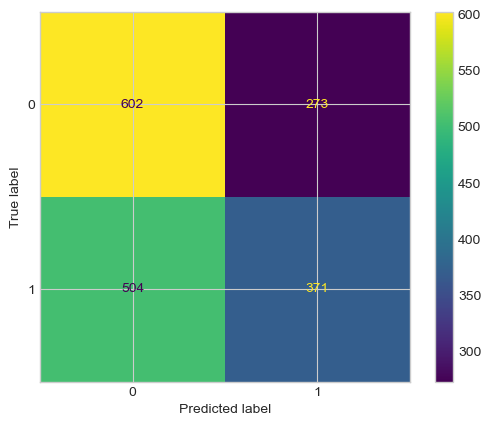

AUC: 0.5559999999999999


In [91]:
metrics.plot_confusion_matrix(pipeline, pca_valid, y_valid)
plt.show()
auc = metrics.roc_auc_score(y_valid, y_pred)
print("AUC:", auc)

### Explanation of what you have achieved, conclusion and perspectives

Start by giving your best result obtained during your submissions

Explain the path that led you there

* What you tried:
    * What worked
    * What didn't work and how you fixed it
* What method did you use to choose the hyperparameters?
* Compare the training time of the main models you used?

What would you have done if you had had more time?

## 7. Save the model predictions

* Use the following code to make predictions and to save them as a ZIP file
* Submit this ZIP file to [the challenge site](https://codalab.lisn.upsaclay.fr/competitions/328#participate-submit_results)
(`Participate > Submit/View Results > Submit`)
* The number of submissions is **limited** to **3 per day** and **30 in total!**
* Try your best to be the ***first on the leaderboard!***

<span style="color:red">
    !! Do not forget to modify the command of the prediction according to the data and models chosen !!
</span>

E.g.:

* Data: `x_test_df` or `x_baseline_test_df`

* Model : `model` or `search` (e.g., for `GridSearchCV`)

In [92]:
model = svm.SVC(C=1)
model.fit(pca_train, y_train)
predictions = model.predict(pca_test)  # compute predictions

PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2023-01-03T14-44-19.zip


---

# Note on the dataset

The dataset does not contain actual medical data. It is not allowed to share these **confidential data** from ICU patients. To avoid this problem, the data have been replaced with **artificial data**.

To have credible data, they were generated using a generative adversarial network (**GAN**) Wasserstein.

For more information: <br/>
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, et al. [Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document). ESANN 2019 - European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, Apr 2019, Bruges, Belgium.

---